In [ ]:
!pip install -q transformers>=4.32.0 datasets evaluate                                                # Comes from HuggingFace
!pip install -q auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/   # Use cu117 if on CUDA 11.7
!pip install -q optimum                                                                               # For GPTQ Optimization
!pip install -q -U bitsandbytes                                                                       # For quantization
!pip install -q -U peft                                                                               # Parameter-efficient Fine-tuning
!pip install -q -U accelerate                                                                         # Loading models across GPUs/CPU/disk
!pip install -q trl==0.8.6                                                                            # For supervised fine-tuning for LLMs
!pip install sacrebleu                                                                                # Evaluation Metric
!pip install scikit-learn                                                                             # Splitting of dataset


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.0/417.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.4 MB/s eta 0:00:00


## This task is done using Google Colab as it is the requirement of this project. Colab GPU is used to run, fine-tune, and in the performance evaluation of the LLaMA 2 7B model. At top, in the notebook, all the necessary installations of libraries are done and imported in the next cell

In [ ]:
import torch
import time
import pandas as pd
import numpy as np
from datasets import load_dataset
import random
import logging
from torch.cuda.amp import autocast
import sacrebleu
from sacrebleu.metrics import BLEU
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import BitsAndBytesConfig
from trl import SFTTrainer
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Login to huggingface is done as model and tokenizer are stored in huggingface repository
from huggingface_hub import notebook_login
# Log in to HF Hub
notebook_login()

#**Dataset Loading and Splitting the dataset **

### Next step is to load the original dataset and split it into a train-test-validation set as the main dataset has 18612 size so it is randomly split into 70\% train, 20\% test, and 10\% validation set. It is very difficult to train and test the model with this split on Google Collab and it would be difficult and inefficient to generate a dataset 3 times the size of the original train dataset so after some trial and error, Random sampling was done from each set. 350 sample size for train, 150 sample size for testing, and 20 sample size for validation dataset were made which is kind of the same split as of original train-test-validation split. Datasets were downloaded in JSON format.

In [ ]:
#Dataset Loading
dataset = load_dataset("iamtarun/python_code_instructions_18k_alpaca")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/18612 [00:00<?, ? examples/s]

In [ ]:
#Dataset is pandas dataframe
df=pd.DataFrame(dataset['train'])

In [ ]:
#Original dataset has four Columns : instriction,inout,output,prompt
df

,instruction,input,output,prompt
0,Create a function to calculate the sum of a se...,"[1, 2, 3, 4, 5]",# Python code\ndef sum_sequence(sequence):\n ...,Below is an instruction that describes a task....
1,Generate a Python code for crawling a website ...,website: www.example.com \ndata to crawl: phon...,import requests\nimport re\n\ndef crawl_websit...,Below is an instruction that describes a task....
2,Create a Python list comprehension to get the ...,,"[x*x for x in [1, 2, 3, 5, 8, 13]]",Below is an instruction that describes a task....
3,Generate a python script to perform this action.,"Given a string, remove all the consecutive dup...",def remove_duplicates(string): \n result = ...,Below is an instruction that describes a task....
4,Write a python script to generates random numb...,,def generate_random_divisible_number():\n i...,Below is an instruction that describes a task....
...,...,...,...,...
18607,Generate a loop in Python which iterates throu...,,for value in list_of_values:\n print(value),Below is an instruction that describes a task....
18608,Can you design a function in Python to sort a ...,"tuples = [(""b"", 0), (""a"", 1), (""c"", -1)]",def sort_tuple(tuples):\n # sort by 2nd ite...,Below is an instruction that describes a task....
18609,Generate a Python function to search an array ...,"Array = [1, 5, 10, 15, 20], Target = 15","def search(array, target):\n # Iterate over ar...",Below is an instruction that describes a task....
18610,Develop an HTTP API in Python to retrieve the ...,,import requests\nfrom bs4 import BeautifulSoup...,Below is an instruction that describes a task....


In [ ]:
# Splitting the data into test and remaining (train + validation)

train_val, test = train_test_split(df, test_size=0.2, random_state=42)

# Splitting the remaining data into training and validation sets
train, val = train_test_split(train_val, test_size=0.125, random_state=42)

In [ ]:
print(f"Training set size: {len(train)} ({len(train)/len(df)*100:.2f}%)")
print(f"Testing set size: {len(test)} ({len(test)/len(df)*100:.2f}%)")
print(f"Validation set size: {len(val)} ({len(val)/len(df)*100:.2f}%)")


Training set size: 13027 (69.99%)
Testing set size: 3723 (20.00%)
Validation set size: 1862 (10.00%)


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'prompt'],
        num_rows: 18612
    })
})

In [ ]:
import random

In [ ]:
#Random Sampling is done to chose new train, test and validation set.
random_state = 42

# Randomly sample rows for the new truncated datasets
new_train = train.sample(n=350, random_state=random_state)
new_test = test.sample(n=150, random_state=random_state)
new_val = val.sample(n=20, random_state=random_state)

# Verify the sizes of the new datasets
print(f"New training set size: {len(new_train)}")
print(f"New testing set size: {len(new_test)}")
print(f"New validation set size: {len(new_val)}")

New training set size: 350
New testing set size: 150
New validation set size: 20


In [ ]:
new_train

,instruction,input,output,prompt
18263,Write a Python program that searches for a sub...,,"def search_substring(string, substring):\n if...",Below is an instruction that describes a task....
6869,Create a script in Python to download the cont...,URL: https://github.com,"import requests\n \nurl = ""https://github.com""...",Below is an instruction that describes a task....
1472,Create a simple Python program that takes in t...,"string1:'Inception', string2: 'Interstellar'",string1 = 'Inception'\nstring2 = 'Interstellar...,Below is an instruction that describes a task....
13819,Write an algorithm in Python to determine the ...,"arr = [10, 8, 12, 4, 6]",def find_max(arr): \n max_val = arr[0] \n ...,Below is an instruction that describes a task....
3940,Develop an array sorting algorithm in Python t...,"[6,5,3,1,8,7,2,4]",def sort_array(arr):\n n = len(arr)\n \n # Ite...,Below is an instruction that describes a task....
...,...,...,...,...
12970,Design a function in Python to find the area o...,5,def areaCircle(radius):\n pi = 3.14\n ar...,Below is an instruction that describes a task....
6795,Construct a function in Python that takes a li...,"list = ['hello', 'world', 'example']",def reverse_list(lst):\n return [s[::-1] fo...,Below is an instruction that describes a task....
2708,Write a Python code to sort a dictionary based...,,"def sort_dict_by_value(in_dict):\n """""" Func...",Below is an instruction that describes a task....
10646,Build a REST API with Python and Flask. The AP...,Not applicable,# Importing libraries\nimport flask\nfrom flas...,Below is an instruction that describes a task....


In [ ]:
new_test

,instruction,input,output,prompt
7539,Construct a Python program to classify the dat...,Classify the following data points into two ca...,def classify_data(data_points):\n classifie...,Below is an instruction that describes a task....
12702,Write a Python script to print the frequency o...,"""Hello world, hello programmer""","words = ""Hello world, hello programmer"".split(...",Below is an instruction that describes a task....
16923,Design a Python class with methods to compute ...,,"""""""\nDesign a Python class with methods to com...",Below is an instruction that describes a task....
1771,Write a python program to classify an object b...,"[2.5, 4.5, 2.5], Classes: [""apple"", ""orange"", ...","def classify_object(features, classes):\n m...",Below is an instruction that describes a task....
2579,Write a function in Python to create a list co...,,def even_numbers():\n even_list = []\n f...,Below is an instruction that describes a task....
...,...,...,...,...
16155,Write an algorithm for detecting a cycle in a ...,Not applicable,def detectLoop(head):\n # Base Case: List i...,Below is an instruction that describes a task....
4140,Create a class to store the details of a perso...,,"class Person:\n def __init__(self, name, ag...",Below is an instruction that describes a task....
3043,Write a Python program to convert a date strin...,"date_string = ""October 15, 2020""",import time \n\ndef convert_to_timestamp(date_...,Below is an instruction that describes a task....
2676,Construct a Python program that reverses an ar...,"[1, 5, 3, 10, 4, 8]",def reverse_array(arr): \n low = 0\n hig...,Below is an instruction that describes a task....


### Original dataset has 4 columns as explained in the dataset section. Only Instruction and Outputs columns data were used, the other 2 were dropped from the train-test-validation datasets. Using Instructions, Inputs, and outputs was highly computationally expensive on Google Collab and data generation was also very difficult. Hence in the end only instructions to Python code or function and its outputs are used.

In [ ]:
# Remove 'input' and 'prompt' columns using the drop method
new_train = new_train.drop(['input', 'prompt'], axis=1)
new_test = new_test.drop(['input', 'prompt'], axis=1)
new_val = new_val.drop(['input', 'prompt'], axis=1)

# Save the DataFrames as JSON files
new_train.to_json('/content/new_train.json', orient='records', lines=True)
new_test.to_json('/content/new_test.json', orient='records', lines=True)
new_val.to_json('/content/new_val.json', orient='records', lines=True)


In [ ]:
new_train

,instruction,output
18263,Write a Python program that searches for a sub...,"def search_substring(string, substring):\n if..."
6869,Create a script in Python to download the cont...,"import requests\n \nurl = ""https://github.com""..."
1472,Create a simple Python program that takes in t...,string1 = 'Inception'\nstring2 = 'Interstellar...
13819,Write an algorithm in Python to determine the ...,def find_max(arr): \n max_val = arr[0] \n ...
3940,Develop an array sorting algorithm in Python t...,def sort_array(arr):\n n = len(arr)\n \n # Ite...
...,...,...
12970,Design a function in Python to find the area o...,def areaCircle(radius):\n pi = 3.14\n ar...
6795,Construct a function in Python that takes a li...,def reverse_list(lst):\n return [s[::-1] fo...
2708,Write a Python code to sort a dictionary based...,"def sort_dict_by_value(in_dict):\n """""" Func..."
10646,Build a REST API with Python and Flask. The AP...,# Importing libraries\nimport flask\nfrom flas...


#**Model A Testing**
### LLaMA 2 7B model is loaded with the tokenizer which is Model A in this task. Model predicts Python code or Function for a given instruction in the test dataset guided by the format\_instruction(); whose effectiveness is measured by BLEU score. NousResearch/Llama-2-7b-hf is used in this task.

In [ ]:
new_test = pd.read_json('/content/new_test.json', lines=True)

In [ ]:
# Convert pandas DataFrame back to Hugging Face Dataset
from datasets import Dataset
test_dataset = Dataset.from_pandas(new_test)


In [ ]:
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf",trust_remote_code=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

### Below function guides the output generation of it returns predicted putput based upon the task and instruction given to it.

In [ ]:
def format_instruction(example):
    instruction = example['instruction']  # Extract the instruction from the dictionary
    return f"""### Instruction:
Use the Task below to write the Python function or code, which can solve the following task.

### Task:
{instruction.strip()}

### Python Function or Code
""".strip()

In [ ]:
predictions = []
for example in test_dataset:
    prompt = format_instruction(example)  # This will only use the 'instruction' field
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model.generate(**inputs.to(model.device), max_new_tokens=100)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


### refs represent reference which have the original ouput from dataset, to be compared with predicted output

In [ ]:
refs = [example['output'].strip() for example in test_dataset]
bleu_score = sacrebleu.corpus_bleu(predictions, [refs])
print(f"BLEU score: {bleu_score.score}")

BLEU score: 5.187195865046942


#**Model A Fine-Tuning (Model B) and Testing of it.**

### Model A (LLaMA 2 7B) is loaded with a quantization configuration and with a tokenizer. In this task, QLORA with 4-bit fine-tuning is used. To guide the model during training, format\_instruction1() which takes instruction and output to train and evaluate the model. Preprocessing to the model is done using prepare\_model\_for\_kbit\_training from PEFT then training arguments are set and passed to the SFT trainer with model, Lora configuration, and the data. Model A is Finetuned on the training and validation dataset, making it Model B. Fine-tuned model and tokenizer were saved on the huggingface repository

In [ ]:
# 1. Setup the quantization configuarion
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Q = 4 bits
    bnb_4bit_use_double_quant=True,        # double quantization, quantizing the quantization constants for memory savings
    bnb_4bit_quant_type="nf4",             # 4-bit NormalFloat Quantization (optimal for normal weights; enforces w ∈ [-1,1])
    bnb_4bit_compute_dtype=torch.bfloat16  # Dequantize to 16-bits before computations (as in the paper)
)
# 2. Pass it while using the model
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf", quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf",trust_remote_code=True, use_fast=True)# use_fast = For fast tokenizer if available,
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

Below Function used for trainer, Both instruction, output are used for this.

In [ ]:
def format_instruction1(instruction, output):
    return f"""### Instruction:
Use the Task  below to write the Python function or code, which can solve the following task.

### Task:
{instruction.strip()}

### Python Function or Code:
{output}
""".strip()

In [ ]:
new_train = pd.read_json('/content/new_train.json', lines=True)
new_test = pd.read_json('/content/new_test.json', lines=True)
new_val=pd.read_json('/content/new_val.json', lines=True)

In [ ]:
len(new_train)

350

In [ ]:
len(new_val)

20

In [ ]:
#Shuffle and select a subset of the DataFrame for training data
train_data = new_train.sample(frac=1, random_state=42).reset_index(drop=True)
train_data = train_data.iloc[:350]

# Shuffle and select a subset of the DataFrame for validation data
validation_data = new_val.sample(frac=1, random_state=42).reset_index(drop=True)
validation_data = validation_data[:20]

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)

Define a function that given a row from the dataset, returns the corresponding prompt:

In [ ]:
def convert_to_instruction_format(example):
    # Assuming 'instruction' and 'output' are the column names in your DataFrame
    formatted_text = format_instruction1(example['instruction'], example['output'])
    return {"text": formatted_text}

In [ ]:
# Apply the function to format the datasets
train_dataset = train_dataset.map(convert_to_instruction_format)
validation_dataset = validation_dataset.map(convert_to_instruction_format)

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['instruction', 'output', 'text'],
    num_rows: 350
})

##PEFT setup

###we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(model)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)

##Training

### Training hyperparameters are set in **TrainingArguments**

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    fp16=True,                           # Training computations in 16 bits
    # batch-related
    per_device_train_batch_size=2,       # Batch Size
    gradient_accumulation_steps=4,       # Batch Size (Mathematically)
    # optimizer-related
    optim="paged_adamw_32bit",           # Variant of AdamW designed to be more efficient on 32-bit GPUs
    learning_rate=1e-4,                  # Learning Rate
    warmup_ratio=0.05,                   # After 5% of the data, learning rate has linearly  from 0 to 1e-4
    lr_scheduler_type="cosine",          # Adjust learning rate sinusoidally
    max_grad_norm=0.3,                   # Clip gradients if less than 0.3 (prevent gradient explosion)
    # epochs and saving
    num_train_epochs=2,                  # Number of Epochs
    save_strategy="epoch",               # Save after each epoch
    output_dir="epoch-finetuned",        # Where to save the model
    # validation
    evaluation_strategy="steps",         # For the next argument
    eval_steps=0.2,                      # Evaluate after 20% of training steps
    # logging-related
    logging_steps=1,                     # Number of update steps between two logs
    group_by_length=True,                # Minimize padding by grouping sentences of similar length
    seed=42,                             # For consistent results
)
model.gradient_checkpointing_enable()    # Store less activations and recompute later
model.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

###the model, the data, the lora configuration and hyperparameters to the Supervised Fine-tuning trainer.

In [ ]:
trainer = SFTTrainer(
    # tokenizer and model
    tokenizer=tokenizer,
    model=model,
    # dataset and text field
    dataset_text_field="text",
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    # LoRA
    peft_config=lora_config,
    # Hyperparameters
    max_seq_length=1024,
    args=training_arguments,
)


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
18,0.598500,0.644310
36,0.501500,0.561432
54,0.510200,0.550792
72,0.491100,0.547756


TrainOutput(global_step=86, training_loss=0.6500482819108075, metrics={'train_runtime': 878.7253, 'train_samples_per_second': 0.797, 'train_steps_per_second': 0.098, 'total_flos': 5602495924322304.0, 'train_loss': 0.6500482819108075, 'epoch': 1.9657142857142857})

In [ ]:
model_repo= 'ashrianmol/Python-code-LLAMA-7B'

In [ ]:
# Save the merged model just in case
trainer.model.save_pretrained("./fine-tuned-llama",safe_serialization=True)
tokenizer.save_pretrained("./fine-tuned-llama")

('./fine-tuned-llama/tokenizer_config.json',
 './fine-tuned-llama/special_tokens_map.json',
 './fine-tuned-llama/tokenizer.model',
 './fine-tuned-llama/added_tokens.json',
 './fine-tuned-llama/tokenizer.json')

###Model and tokenizer is pushed to huggingface repository to be loaded again at inference time later

In [ ]:
trainer.model.push_to_hub(model_repo)


adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashrianmol/Python-code-LLAMA-7B/commit/ec8bc08054bc85843838bed6eaf6f2edf97f2c13', commit_message='Upload model', commit_description='', oid='ec8bc08054bc85843838bed6eaf6f2edf97f2c13', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub(model_repo)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashrianmol/Python-code-LLAMA-7B/commit/7ff081ba408335242b08412b1ce537d817093134', commit_message='Upload tokenizer', commit_description='', oid='7ff081ba408335242b08412b1ce537d817093134', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
tuned_model = AutoPeftModelForCausalLM.from_pretrained(model_repo, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_repo)

adapter_config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

In [ ]:
test_dataset= Dataset.from_pandas(new_test)
test_dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 150
})

In [ ]:
def format_instruction(example):
    instruction = example['instruction']  # Extract the instruction from the dictionary
    return f"""### Instruction:
Use the Task below to write the Python function or code, which can solve the following task.

### Task:
{instruction.strip()}

### Python Function or Code
""".strip()

###Predictions are done with max_length=128 and BLEU score is evaluate. This is the score used for visualization.

In [ ]:
predictions = []
for example in test_dataset:
    prompt = format_instruction(example)  # This will only use the 'instruction' field
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = tuned_model.generate(**inputs.to(tuned_model.device), max_new_tokens=100)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(prediction)

In [ ]:
refs = [example['output'].strip() for example in test_dataset]
bleu_score = sacrebleu.corpus_bleu(predictions, [refs])
print(f"BLEU score: {bleu_score.score}")

BLEU score: 10.348785262298826


###Predictions are done with max_length=256 and BLEU score is evaluate. Just to show that changing max_length improves the score amost 0.5 in this case. This scores were not used for visualization because prediction from base model(Model A) would take lot resource computation.

In [ ]:
predictions = []
for example in test_dataset:
    prompt = format_instruction(example)  # This will only use the 'instruction' field
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = tuned_model.generate(**inputs.to(tuned_model.device), max_new_tokens=100)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [ ]:
refs = [example['output'].strip() for example in test_dataset]
bleu_score = sacrebleu.corpus_bleu(predictions, [refs])
print(f"BLEU score: {bleu_score.score}")

BLEU score: 10.615822883370535


#**Model A is finetuned Synthetic dataset(Model C) and evaluated.**
###Synthetic dataset is loaded. Model A is fine-tuned on Training and validation sets which were made from the synthetic dataset with random sampling(same way as defined above). The fine-tuned model is saved on the hugging face repository with the tokenizer. Model C is loaded from the hugging face with a tokenizer. Finally, Model C was evaluated on the testing dataset using the BLEU score.


In [ ]:
# 1. Setup the quantization configuarion
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Q = 4 bits
    bnb_4bit_use_double_quant=True,        # double quantization, quantizing the quantization constants for memory savings
    bnb_4bit_quant_type="nf4",             # 4-bit NormalFloat Quantization (optimal for normal weights; enforces w ∈ [-1,1])
    bnb_4bit_compute_dtype=torch.bfloat16  # Dequantize to 16-bits before computations (as in the paper)
)
# 2. Pass it while using the model
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf", quantization_config=bnb_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf",trust_remote_code=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
def format_instruction1(instruction, output):
    return f"""### Instruction:
Use the Task below to write the Python function or code, which can solve the following task.

### Task:
{instruction.strip()}

### Python Function or Code:
{output}
""".strip()

In [ ]:
#Synthetic_dataset being loaded
df1= pd.read_csv('/content/Synthetic_dataset.csv')

In [ ]:
df1

,instruction,output
0,Create a Python program to create a simple web...,import http.server as
1,Create a Python program,"def find_common(arr1, arr2): for x in arr1: fo..."
2,Develop a Python program to check if a given s...,def is_palind
3,Create a Python program to print the first 1,"import requests response = requests.get(""https..."
4,Develop a Python function to convert a given s...,def convert_to_palindrome(original_string): re...
...,...,...
1046,"Using the Pygame library, create a Python prog...",import pygame pygame.init() window_size = (500...
1047,Write a Python program to find the smallest ke...,def smallest_key(dict):
1048,"Using Python, develop a",def find_standard_deviation(list): import nump...
1049,Write a Python program to find the maximum num...,def first_nonsquare(n): for i in range(n): if ...


In [ ]:
#Train and validation set are made split is 90% for training and 10% for validation
from sklearn.model_selection import train_test_split
train_df, validation_df = train_test_split(df1, test_size=0.1, random_state=42)

In [ ]:
len(train_df)

945

In [ ]:
len(validation_df)

106

In [ ]:
#Shuffle and select a subset of the DataFrame for training data
train_data_syn = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_data_syn = train_data_syn.iloc[:945]

# Shuffle and select a subset of the DataFrame for validation data
validation_data_syn = validation_df.sample(frac=1, random_state=42).reset_index(drop=True)
validation_data_syn = validation_data_syn[:106]

In [ ]:
from datasets import Dataset
train_dataset_syn = Dataset.from_pandas(train_data_syn)
validation_dataset_syn = Dataset.from_pandas(validation_data_syn)

In [ ]:
def convert_to_instruction_format(example):
    # 'instruction' and 'output' are the column names in DataFrame
    formatted_text = format_instruction1(example['instruction'], example['output'])
    return {"text": formatted_text}

In [ ]:
# Apply the function to format the datasets
train_dataset_syn = train_dataset_syn.map(convert_to_instruction_format)
validation_dataset_syn = validation_dataset_syn.map(convert_to_instruction_format)

Map:   0%|          | 0/945 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

In [ ]:
new_test = pd.read_json('/content/new_test.json', lines=True)
test_dataset= Dataset.from_pandas(new_test)
test_dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 150
})

##PEFT Setup

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(model)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)

##Training of Model A on synthetic dataset

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    fp16=True,                           # Training computations in 16 bits
    # batch-related
    per_device_train_batch_size=2,       # Batch Size
    gradient_accumulation_steps=4,       # Batch Size (Mathematically)
    # optimizer-related
    optim="paged_adamw_32bit",           # Variant of AdamW designed to be more efficient on 32-bit GPUs
    learning_rate=1e-4,                  # Learning Rate
    warmup_ratio=0.05,                   # After 5% of the data, learning rate has linearly  from 0 to 1e-4
    lr_scheduler_type="cosine",          # Adjust learning rate sinusoidally
    max_grad_norm=0.3,                   # Clip gradients if less than 0.3 (prevent gradient explosion)
    # epochs and saving
    num_train_epochs=2,                  # Number of Epochs
    save_strategy="epoch",               # Save after each epoch
    output_dir="epoch-finetuned",        # Where to save the model
    # validation
    evaluation_strategy="steps",         # For the next argument
    eval_steps=0.2,                      # Evaluate after 20% of training steps
    # logging-related
    logging_steps=1,                     # Number of update steps between two logs
    group_by_length=True,                # Minimize padding by grouping sentences of similar length
    seed=42,                             # For consistent results
)
model.gradient_checkpointing_enable()    # Store less activations and recompute later
model.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

In [ ]:
trainer_syn = SFTTrainer(
    # tokenizer and model
    tokenizer=tokenizer,
    model=model,
    # dataset and text field
    dataset_text_field="text",
    train_dataset=train_dataset_syn,
    eval_dataset=validation_dataset_syn,
    # LoRA
    peft_config=lora_config,
    # Hyperparameters
    max_seq_length=1024,
    args=training_arguments,
)


Map:   0%|          | 0/945 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

###Emptying Virtual ram and cuda cache with garbage collection

In [ ]:
# Empty VRAM
import gc
gc.collect()
gc.collect()

0

In [ ]:
torch.cuda.empty_cache() # PyTorch thing

In [ ]:
gc.collect()

0

In [ ]:
trainer_syn.train()

Step,Training Loss,Validation Loss
48,0.361400,0.352832
96,0.317200,0.307851
144,0.244000,0.291165
192,0.201000,0.278104


TrainOutput(global_step=236, training_loss=0.3993453962444249, metrics={'train_runtime': 1674.5514, 'train_samples_per_second': 1.129, 'train_steps_per_second': 0.141, 'total_flos': 6560025838829568.0, 'train_loss': 0.3993453962444249, 'epoch': 1.9957716701902748})

In [ ]:
model_repo1="ashrianmol/Python-Code-Synthetic-LLAMA7B"

In [ ]:
# Save the merged model
trainer_syn.model.save_pretrained("./fine-tuned-llama_syn",safe_serialization=True)
tokenizer.save_pretrained("./fine-tuned-llama_syn")

('./fine-tuned-llama_syn/tokenizer_config.json',
 './fine-tuned-llama_syn/special_tokens_map.json',
 './fine-tuned-llama_syn/tokenizer.model',
 './fine-tuned-llama_syn/added_tokens.json',
 './fine-tuned-llama_syn/tokenizer.json')

### Model C and tokenizer  is pushed to huggingface.

In [ ]:
trainer_syn.model.push_to_hub(model_repo1)

adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashrianmol/Python-Code-Synthetic-LLAMA7B/commit/b6e2f4a8280894f693b9ea3674c8839c29459061', commit_message='Upload model', commit_description='', oid='b6e2f4a8280894f693b9ea3674c8839c29459061', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub(model_repo1)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashrianmol/Python-Code-Synthetic-LLAMA7B/commit/070f459f65758429d6f46c0334ebd504f1f196d5', commit_message='Upload tokenizer', commit_description='', oid='070f459f65758429d6f46c0334ebd504f1f196d5', pr_url=None, pr_revision=None, pr_num=None)

### Model, trainer model is deleted to free up the GPU menory and virtual memory

In [ ]:
del model
del trainer_syn
del tokenizer
import gc
gc.collect()
gc.collect()

0

In [ ]:
torch.cuda.empty_cache() # PyTorch thing

In [ ]:
gc.collect()

18

##Inference

###Model C is loaded from huggingface repository with tokenizer.

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
tuned_model = AutoPeftModelForCausalLM.from_pretrained(model_repo1, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_repo1)

adapter_config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

In [ ]:
def format_instruction(example):
    instruction = example['instruction']  # Extract the instruction from the dictionary
    return f"""### Instruction:
Use the Task below to write the Python function or code, which can solve the following task.

### Task:
{instruction.strip()}

### Python Function or Code
""".strip()

In [ ]:
test_dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 150
})

###Testing and BLEU Score is being evalauted with max_length=128, used in visualization score of Model C.

In [ ]:
predictions = []
for example in test_dataset:
    prompt = format_instruction(example)  # This will only use the 'instruction' field
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = tuned_model.generate(**inputs.to(tuned_model.device), max_new_tokens=100)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, 

In [ ]:
refs = [example['output'].strip() for example in test_dataset]
bleu_score = sacrebleu.corpus_bleu(predictions, [refs])
print(f"BLEU score: {bleu_score.score}")

BLEU score: 7.346089588937305


###Predictions with max_length =256 shows increased BLEU score.

In [ ]:
predictions = []
for example in test_dataset:
    prompt = format_instruction(example)  # This will only use the 'instruction' field
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = tuned_model.generate(**inputs.to(tuned_model.device), max_new_tokens=100)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [ ]:
refs = [example['output'].strip() for example in test_dataset]
bleu_score = sacrebleu.corpus_bleu(predictions, [refs])
print(f"BLEU score: {bleu_score.score}")

BLEU score: 7.593066305142642


#Model A Fine-Tuned on merged dataset(Model D) and tested + evaluated using BLEU score.

###The Merged dataset was made by concatenating training and synthetic dataset and the Merged dataset was shuffled with random seed =42 and converted- stored in JSON format. The size of the Merged Dataset was 1401. For finetuning model A on the merged dataset same approach was followed as described in the above points. The fine-tuned model is stored on a hugging face repository with a tokenizer,  making it Model D. Model D is loaded from the hugging face with its tokenizer to be tested and evaluated on the testing dataset using the BLEU score.

In [ ]:
df_train = pd.read_json('/content/new_train.json', lines=True)
df_test = pd.read_json('/content/new_test.json', lines=True)
df_shuffled_data=pd.read_json('/content/merged_dataset.json', lines=True)

NameError: name 'pd' is not defined

In [ ]:
df_train


,instruction,output
0,Write a Python program that searches for a sub...,"def search_substring(string, substring):\n if..."
1,Create a script in Python to download the cont...,"import requests\n \nurl = ""https://github.com""..."
2,Create a simple Python program that takes in t...,string1 = 'Inception'\nstring2 = 'Interstellar...
3,Write an algorithm in Python to determine the ...,def find_max(arr): \n max_val = arr[0] \n ...
4,Develop an array sorting algorithm in Python t...,def sort_array(arr):\n n = len(arr)\n \n # Ite...
...,...,...
345,Design a function in Python to find the area o...,def areaCircle(radius):\n pi = 3.14\n ar...
346,Construct a function in Python that takes a li...,def reverse_list(lst):\n return [s[::-1] fo...
347,Write a Python code to sort a dictionary based...,"def sort_dict_by_value(in_dict):\n """""" Func..."
348,Build a REST API with Python and Flask. The AP...,# Importing libraries\nimport flask\nfrom flas...


In [ ]:
df_synthetic = pd.read_csv('/Synthetic_dataset.csv')

In [ ]:
df_synthetic

,instruction,output
0,Create a Python program to create a simple web...,import http.server as
1,Create a Python program,"def find_common(arr1, arr2): for x in arr1: fo..."
2,Develop a Python program to check if a given s...,def is_palind
3,Create a Python program to print the first 1,"import requests response = requests.get(""https..."
4,Develop a Python function to convert a given s...,def convert_to_palindrome(original_string): re...
...,...,...
1046,"Using the Pygame library, create a Python prog...",import pygame pygame.init() window_size = (500...
1047,Write a Python program to find the smallest ke...,def smallest_key(dict):
1048,"Using Python, develop a",def find_standard_deviation(list): import nump...
1049,Write a Python program to find the maximum num...,def first_nonsquare(n): for i in range(n): if ...


In [ ]:
#Merged dataset is made from concatenating both train and synthetic dataset
df_merged_data = pd.concat([df_train, df_synthetic], ignore_index=True)

In [ ]:
df_merged_data

,instruction,output
0,Write a Python program that searches for a sub...,"def search_substring(string, substring):\n if..."
1,Create a script in Python to download the cont...,"import requests\n \nurl = ""https://github.com""..."
2,Create a simple Python program that takes in t...,string1 = 'Inception'\nstring2 = 'Interstellar...
3,Write an algorithm in Python to determine the ...,def find_max(arr): \n max_val = arr[0] \n ...
4,Develop an array sorting algorithm in Python t...,def sort_array(arr):\n n = len(arr)\n \n # Ite...
...,...,...
1396,"Using the Pygame library, create a Python prog...",import pygame pygame.init() window_size = (500...
1397,Write a Python program to find the smallest ke...,def smallest_key(dict):
1398,"Using Python, develop a",def find_standard_deviation(list): import nump...
1399,Write a Python program to find the maximum num...,def first_nonsquare(n): for i in range(n): if ...


In [ ]:
# Merged data is shuffled with random seed 42
df_shuffled_data = df_merged_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Save the shuffled DataFrame as a JSON file
df_shuffled_data.to_json('/content/merged_dataset.json', orient='records', lines=True)

In [ ]:
df_shuffled_data

,instruction,output
0,Develop a Python function to check if a given ...,def is_palindrome(string): return string == st...
1,Write a Python program to find the first occur...,"def first_occurrence(arr, value): for i in ran..."
2,Generate a Python function that takes an integ...,def num_unique_elements(arr):\n unique_arr ...
3,Create a Python function to calculate the,def median(numbers): nums = sorted(numbers) re...
4,"Using the Requests library, create a Python sc...","import requests response = requests.get("""
...,...,...
1396,Write a Python script to calculate the product...,def sum_digits(n): return sum(str(n))
1397,Create a Python program to find the longest co...,"def longest_common_subsequence(str1, str2): m ..."
1398,Write a Python function to find the maximum ke...,def max_key(d): return max
1399,Write a Python script to read a text file and ...,def count_words(file_name): with open(file_nam...


###Loading Quantized Model

In [ ]:
# 1. Setup the quantization configuarion
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Q = 4 bits
    bnb_4bit_use_double_quant=True,        # double quantization, quantizing the quantization constants for memory savings
    bnb_4bit_quant_type="nf4",             # 4-bit NormalFloat Quantization (optimal for normal weights; enforces w ∈ [-1,1])
    bnb_4bit_compute_dtype=torch.bfloat16  # Dequantize to 16-bits before computations (as in the paper)
)
# 2. Pass it while using the model
model = AutoModelForCausalLM.from_pretrained("NousResearch/Llama-2-7b-hf", quantization_config=bnb_config, device_map="auto")

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-hf",trust_remote_code=True, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
def format_instruction1(instruction, output):
    return f"""### Instruction:
Use the Task below to write the Python function or code, which can solve the following task.

### Task:
{instruction.strip()}

### Python Function or Code:
{output}
""".strip()

In [ ]:
#Merged taining and merged validation set are made with 90-10 split.
from sklearn.model_selection import train_test_split
train_merged_df, validation__merged_df = train_test_split(df_shuffled_data, test_size=0.1, random_state=42)

In [ ]:
len(train_merged_df)

1260

In [ ]:
len(validation__merged_df)

141

In [ ]:
#Shuffle and select a subset of the DataFrame for training data
train_data_merged = train_merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_data_merged = train_data_merged.iloc[:1246]

# Shuffle and select a subset of the DataFrame for validation data
validation_data_merged = validation__merged_df.sample(frac=1, random_state=42).reset_index(drop=True)
validation_data_merged = validation_data_merged[:141]

In [ ]:
from datasets import Dataset
train_dataset_merged = Dataset.from_pandas(train_data_merged)
validation_dataset_merged = Dataset.from_pandas(validation_data_merged)

In [ ]:
train_dataset_merged

Dataset({
    features: ['instruction', 'output'],
    num_rows: 1246
})

In [ ]:
def convert_to_instruction_format(example):
    #'instruction' and 'output' are the column names in DataFrame
    formatted_text = format_instruction1(example['instruction'], example['output'])
    return {"text": formatted_text}

In [ ]:
# Apply the function to format the datasets
train_dataset_merged = train_dataset_merged.map(convert_to_instruction_format)
validation_dataset_merged = validation_dataset_merged.map(convert_to_instruction_format)

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

##PEFT setup

In [ ]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# 1. prepare model for LoRA
model = prepare_model_for_kbit_training(model)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)

##Training Model on merged dataset

In [ ]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    fp16=True,                           # Training computations in 16 bits
    # batch-related
    per_device_train_batch_size=2,       # Batch Size
    gradient_accumulation_steps=4,       # Batch Size (Mathematically)
    # optimizer-related
    optim="paged_adamw_32bit",           # Variant of AdamW designed to be more efficient on 32-bit GPUs
    learning_rate=1e-4,                  # Learning Rate
    warmup_ratio=0.05,                   # After 5% of the data, learning rate has linearly  from 0 to 1e-4
    lr_scheduler_type="cosine",          # Adjust learning rate sinusoidally
    max_grad_norm=0.3,                   # Clip gradients if less than 0.3 (prevent gradient explosion)
    # epochs and saving
    num_train_epochs=2,                  # Number of Epochs
    save_strategy="epoch",               # Save after each epoch
    output_dir="epoch-finetuned",        # Where to save the model
    # validation
    evaluation_strategy="steps",         # For the next argument
    eval_steps=0.2,                      # Evaluate after 20% of training steps
    # logging-related
    logging_steps=1,                     # Number of update steps between two logs
    group_by_length=True,                # Minimize padding by grouping sentences of similar length
    seed=42,                             # For consistent results
)
model.gradient_checkpointing_enable()    # Store less activations and recompute later
model.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

In [ ]:
trainer_merged = SFTTrainer(
    # tokenizer and model
    tokenizer=tokenizer,
    model=model,
    # dataset and text field
    dataset_text_field="text",
    train_dataset=train_dataset_merged,
    eval_dataset=validation_dataset_merged,
    # LoRA
    peft_config=lora_config,
    # Hyperparameters
    max_seq_length=1024,
    args=training_arguments,
)


Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/141 [00:00<?, ? examples/s]

In [ ]:
trainer_merged.train()

Step,Training Loss,Validation Loss
62,0.336800,0.485368
124,0.504300,0.457313
186,0.267600,0.445301
248,0.371100,0.437796
310,0.448800,0.435534


TrainOutput(global_step=310, training_loss=0.4363458687739988, metrics={'train_runtime': 2774.6172, 'train_samples_per_second': 0.898, 'train_steps_per_second': 0.112, 'total_flos': 1.1292509733076992e+16, 'train_loss': 0.4363458687739988, 'epoch': 1.9903691813804172})

In [ ]:
modelrepo2='ashrianmol/Python-Merged-LLAMA7B'

In [ ]:
# Save the merged model
trainer_merged.model.save_pretrained("./fine-tuned-llama",safe_serialization=True)
tokenizer.save_pretrained("./fine-tuned-llama")

('./fine-tuned-llama/tokenizer_config.json',
 './fine-tuned-llama/special_tokens_map.json',
 './fine-tuned-llama/tokenizer.model',
 './fine-tuned-llama/added_tokens.json',
 './fine-tuned-llama/tokenizer.json')

##Model D with tokenizer pushed to higgingface repository

In [ ]:
trainer_merged.model.push_to_hub(modelrepo2)

adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashrianmol/Python-Merged-LLAMA7B/commit/bf0cdca0bc948b75d6f76b22382b7561836b55fc', commit_message='Upload model', commit_description='', oid='bf0cdca0bc948b75d6f76b22382b7561836b55fc', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub(modelrepo2)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ashrianmol/Python-Merged-LLAMA7B/commit/031fe5217df0741bfd211687d7eb6019fb2dfd20', commit_message='Upload tokenizer', commit_description='', oid='031fe5217df0741bfd211687d7eb6019fb2dfd20', pr_url=None, pr_revision=None, pr_num=None)

##Inference

###Model D  with tokenizer is loaded from huggingface repository

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
tuned_model = AutoPeftModelForCausalLM.from_pretrained(modelrepo2, low_cpu_mem_usage=True, torch_dtype=torch.float16, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(modelrepo2)

adapter_config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

In [ ]:
df_test

,instruction,output
0,Construct a Python program to classify the dat...,def classify_data(data_points):\n classifie...
1,Write a Python script to print the frequency o...,"words = ""Hello world, hello programmer"".split(..."
2,Design a Python class with methods to compute ...,"""""""\nDesign a Python class with methods to com..."
3,Write a python program to classify an object b...,"def classify_object(features, classes):\n m..."
4,Write a function in Python to create a list co...,def even_numbers():\n even_list = []\n f...
...,...,...
145,Write an algorithm for detecting a cycle in a ...,def detectLoop(head):\n # Base Case: List i...
146,Create a class to store the details of a perso...,"class Person:\n def __init__(self, name, ag..."
147,Write a Python program to convert a date strin...,import time \n\ndef convert_to_timestamp(date_...
148,Construct a Python program that reverses an ar...,def reverse_array(arr): \n low = 0\n hig...


In [ ]:
def format_instruction(example):
    instruction = example['instruction']  # Extract the instruction from the dictionary
    return f"""### Instruction:
Use the Task below to write the Python function or code, which can solve the following task.

### Task:
{instruction.strip()}

### Python Function or Code
""".strip()

In [ ]:
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
test_dataset

Dataset({
    features: ['instruction', 'output'],
    num_rows: 150
})

###Predictions and BLEU score based on max_length=128. Used in visualization score of Model D

In [ ]:
predictions = []
for example in test_dataset:
    prompt = format_instruction(example)  # This will only use the 'instruction' field
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = tuned_model.generate(**inputs.to(tuned_model.device), max_new_tokens=100)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, 

In [ ]:
refs = [example['output'].strip() for example in test_dataset]
bleu_score = sacrebleu.corpus_bleu(predictions, [refs])
print(f"BLEU score: {bleu_score.score}")

BLEU score: 8.322036769431598


###Predictions and BLEU score based on max_length=256.

In [ ]:
predictions = []
for example in test_dataset:
    prompt = format_instruction(example)  # This will only use the 'instruction' field
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = tuned_model.generate(**inputs.to(tuned_model.device), max_new_tokens=100)
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predictions.append(prediction)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [ ]:
refs = [example['output'].strip() for example in test_dataset]
bleu_score = sacrebleu.corpus_bleu(predictions, [refs])
print(f"BLEU score: {bleu_score.score}")

BLEU score: 8.848187000331034


#**Visualization **

### BLEU scores from all model were taken and visualized using a bar chart which shows scores on the y-axis and model type on the x-axis. The chart is implemented using matplotlib.

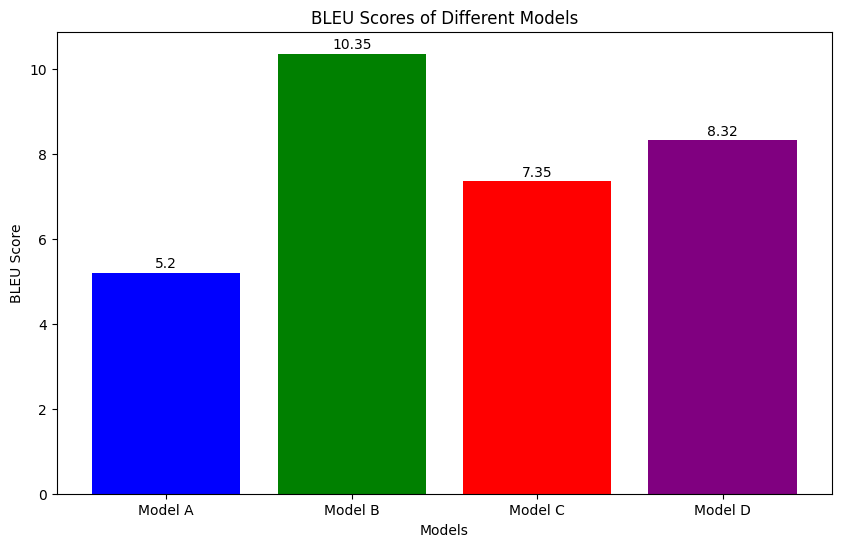

In [ ]:
#  4 BLEU scores in a list
bleu_scores = [5.2,10.35, 7.35,8.32]  #  actual BLEU scores
model_names = ['Model A', 'Model B', 'Model C', 'Model D']  # Names of the models
colors = ['blue', 'green', 'red', 'purple']  # Colors for the bars

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, bleu_scores, color=colors)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores of Different Models')

# Show the bar chart
plt.show()
